In [1]:
import time
import sys
import inspect #디버깅용
import torch
import torchvision
import click
from PIL import Image
from torchvision import transforms
import numpy as np
import pickle
from IPython.display import clear_output

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def time_stamp():
    temp = r"%Y-%m-%d %H:%M:%S"
    current_frame = inspect.currentframe()
    tmp = f"{time.strftime(temp, time.localtime(time.time() + 32400))}: [{inspect.getframeinfo(current_frame).filename}]:"
    return tmp

def version_all():
    print(f"{time_stamp()}Python 버전📌 {sys.version_info}")
    print(f"{time_stamp()}Pytorch 버전📌 {torch.__version__}")
    print(f"{time_stamp()}torchvision 버전📌 {torchvision.__version__}")
    print(f"{time_stamp()}Torch GPU 가능여부📌 {torch.torch.cuda.is_available()}")
    print(f"{time_stamp()}Click Version📌 {click.__version__}") 
    print(f"{time_stamp()}Numpy Version📌 {np.__version__}")
    
# GPU 사용 설정
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # print("GPU 설정 완료")
# else:
    # print("GPU를 찾을 수 없습니다. CPU")


version_all()
print(f"{'='*100}")
!nvcc -V

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:Python 버전📌 sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)
2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:Pytorch 버전📌 1.13.1
2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:torchvision 버전📌 0.14.1
2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:Torch GPU 가능여부📌 True
2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:Click Version📌 8.1.7
2023-09-17 19:29:07: [/tmp/ipykernel_383/1425864586.py]:Numpy Version📌 1.24.3
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
!pwd

/step1


In [4]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("/step1/input/ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
df = df[df['rating']>=3]
print(len(df))

82520


In [6]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [7]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)

In [8]:
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  66016
Test Size :  16504


In [40]:
pd.DataFrame(train['user_id'].values)

,0
0,770
1,169
2,327
3,85
4,548
...,...
66011,807
66012,145
66013,602
66014,622


In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [10]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print(len(test))

943 1546
16472


In [11]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [12]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1546


latent_dim is the length of the user/item embedding.
n_layers is the number of times we want to propagate our initial user/item embedding through the graph

In [13]:
latent_dim = 64
n_layers = 3 

In [14]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [15]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

In [16]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [17]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

In [18]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([2489, 64])


In [19]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

In [20]:
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
  
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [21]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [22]:
EPOCHS = 30
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 10

In [24]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = [] 

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    best_ndcg = -1
  
    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
    
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg
      
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')
     

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)  

  0%|          | 0/30 [00:00<?, ?it/s]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

  7%|▋         | 2/30 [00:03<00:52,  1.88s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 10%|█         | 3/30 [00:05<00:50,  1.86s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 13%|█▎        | 4/30 [00:07<00:48,  1.86s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 17%|█▋        | 5/30 [00:09<00:46,  1.85s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 20%|██        | 6/30 [00:11<00:44,  1.86s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 23%|██▎       | 7/30 [00:13<00:42,  1.86s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 27%|██▋       | 8/30 [00:15<00:41,  1.90s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 30%|███       | 9/30 [00:16<00:40,  1.91s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 33%|███▎      | 10/30 [00:19<00:39,  1.99s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 37%|███▋      | 11/30 [00:21<00:37,  1.97s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 40%|████      | 12/30 [00:23<00:35,  1.97s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 43%|████▎     | 13/30 [00:24<00:32,  1.93s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 47%|████▋     | 14/30 [00:26<00:31,  1.95s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 50%|█████     | 15/30 [00:28<00:29,  1.94s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 57%|█████▋    | 17/30 [00:32<00:24,  1.91s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 60%|██████    | 18/30 [00:34<00:23,  1.92s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 63%|██████▎   | 19/30 [00:36<00:21,  1.91s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 67%|██████▋   | 20/30 [00:38<00:19,  1.91s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 70%|███████   | 21/30 [00:40<00:17,  1.90s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 73%|███████▎  | 22/30 [00:42<00:15,  1.90s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 77%|███████▋  | 23/30 [00:43<00:13,  1.90s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 80%|████████  | 24/30 [00:45<00:11,  1.92s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 83%|████████▎ | 25/30 [00:47<00:09,  1.91s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 87%|████████▋ | 26/30 [00:49<00:07,  1.96s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 90%|█████████ | 27/30 [00:51<00:05,  1.96s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 93%|█████████▎| 28/30 [00:53<00:03,  1.99s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

 97%|█████████▋| 29/30 [00:55<00:01,  1.97s/it]

LightGCN(
  (E0): Embedding(2489, 64)
)

LightGCN(
  (E0): Embedding(2489, 64)
)

100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


In [25]:
epoch_list = [(i+1) for i in range(EPOCHS)]

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Metrics')

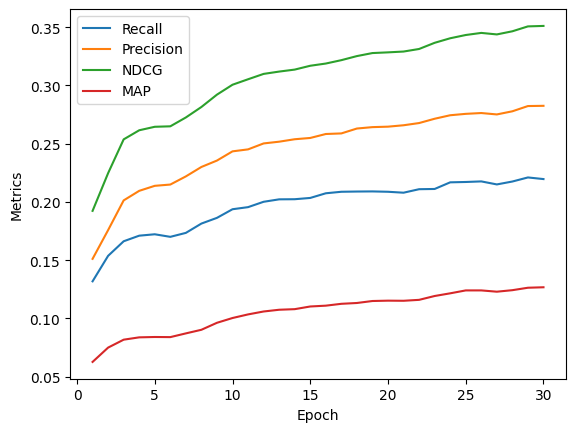

In [26]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

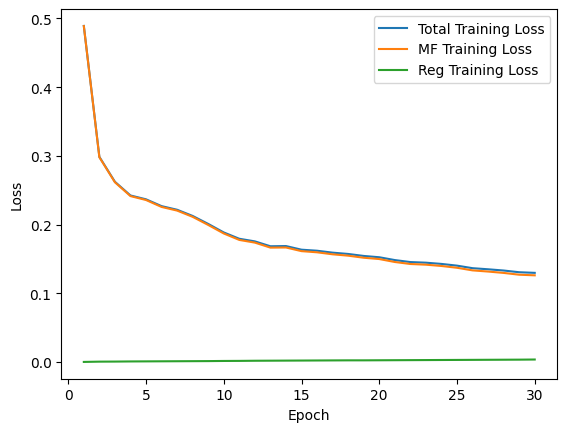

In [27]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [28]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  1.84  seconds
Averge time taken to eval an epoch ->  0.08  seconds


In [29]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2196
Last Epoch's Test Data Precision ->  0.2825
Last Epoch's Test Data NDCG ->  0.3511
Last Epoch's Test Data MAP ->  0.1267
Last Epoch's Train Data Loss ->  0.1298


In [34]:
! pip install -q tensorflow

In [35]:
!git clone https://github.com/microsoft/recommenders.git ./recommenders_microsoft

Cloning into './recommenders_microsoft'...
remote: Enumerating objects: 38312, done.
remote: Counting objects: 100% (1844/1844), done.
remote: Compressing objects: 100% (776/776), done.
remote: Total 38312 (delta 1140), reused 1586 (delta 1011), pack-reused 36468
Receiving objects: 100% (38312/38312), 207.30 MiB | 22.10 MiB/s, done.
Resolving deltas: 100% (25798/25798), done.
